# GP - Unscented Transformation
This notebook, I will go over how we can implement the Gaussian process (GP) regression algorithm using Jax. This isn't a new algorithm or anything but I would like to get accustomed to using Jax because it will be useful later when I implement the GPs to handle uncertain inputs.

**Inspirations**

* [SSMToyBox](https://github.com/jacobnzw/SSMToybox/blob/master/ssmtoybox/mtran.py#L62)
* [GPyTorch PILCO](https://github.com/jaztsong/PILCO-gpytorch/blob/master/pilco/models/mgpr.py#L282)
* [PyRoboLearn](https://github.com/robotlearn/pyrobolearn/blob/master/pyrobolearn/filters/unscented_kalman_filter.py)
* FilterPy - [UKF](https://github.com/rlabbe/filterpy/blob/master/filterpy/kalman/UKF.py) | [Unscented Transform](https://github.com/rlabbe/filterpy/blob/master/filterpy/kalman/unscented_transform.py)

## Imports

In [1]:
import sys
from pyprojroot import here
sys.path.append(str(here()))
import pathlib
PATH = pathlib.Path(here())

import functools
from typing import Callable, Dict, Tuple
import argparse
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

sns.reset_defaults()
# sns.set_style('whitegrid')
# sns.set_context('talk')
sns.set_context(context="talk", font_scale=0.7)

import numpy as onp
import numpyro
import numpyro.distributions as dist
import tqdm
from jax.experimental import optimizers

from src.models.jaxgp.data import get_data, near_square_wave
from src.models.jaxgp.exact import predictive_mean, predictive_variance
from src.models.jaxgp.kernels import gram, rbf_kernel, ard_kernel
from src.models.jaxgp.loss import marginal_likelihood
from src.models.jaxgp.mean import zero_mean
from src.models.jaxgp.utils import cholesky_factorization, get_factorizations, saturate

# LOGGING SETTINGS
import sys
import logging
logging.basicConfig(
    level=logging.INFO, 
    stream=sys.stdout,
    format='%(asctime)s:%(levelname)s:%(message)s'
)
logger = logging.getLogger()

%load_ext autoreload
%autoreload 2

## Data

In [2]:
from dataclasses import dataclass

@dataclass
class args:
    num_train = 80
    num_test = 1_000
    smoke_test = False
    input_noise = 0.3
    output_noise = 0.15

# sigma_inputs = 0.15
input_cov = jnp.array([args.input_noise]).reshape(-1, 1)
X, y, Xtest, ytest = near_square_wave(
    n_train=args.num_train,
    input_noise=args.input_noise,
    output_noise=args.output_noise,
    n_test=args.num_test,
)

## Model

In [3]:
# PRIOR FUNCTIONS (mean, covariance)
mu_f = zero_mean
cov_f = functools.partial(gram, ard_kernel)
gp_priors = (mu_f, cov_f)

# Kernel, Likelihood parameters
params = {
    # "gamma": 2.0,
    "length_scale": 1.0,
    "var_f": 1.0,
    "likelihood_noise": 1.0,
}
# saturate parameters with likelihoods
params = saturate(params)

# LOSS FUNCTION
mll_loss = jax.jit(functools.partial(marginal_likelihood, gp_priors))

# GRADIENT LOSS FUNCTION
dloss = jax.jit(jax.grad(mll_loss))

## Optimizer

In [4]:
# STEP FUNCTION
@jax.jit
def step(params, X, y, opt_state):
    # calculate loss
    loss = mll_loss(params, X, y)

    # calculate gradient of loss
    grads = dloss(params, X, y)

    # update optimizer state
    opt_state = opt_update(0, grads, opt_state)

    # update params
    params = get_params(opt_state)

    return params, opt_state, loss

## Training

In [5]:
# TRAINING PARARMETERS
n_epochs = 500 if not args.smoke_test else 2
learning_rate = 0.01
losses = list()

# initialize optimizer
opt_init, opt_update, get_params = optimizers.rmsprop(step_size=learning_rate)

# initialize parameters
opt_state = opt_init(params)

# get initial parameters
params = get_params(opt_state)

postfix = {}

with tqdm.trange(n_epochs) as bar:

    for i in bar:
        # 1 step - optimize function
        params, opt_state, value = step(params, X, y, opt_state)

        # update params
        postfix = {}
        for ikey in params.keys():
            postfix[ikey] = f"{jax.nn.softplus(params[ikey]):.2f}"

        # save loss values
        losses.append(value.mean())

        # update progress bar
        postfix["Loss"] = f"{onp.array(losses[-1]):.2f}"
        bar.set_postfix(postfix)
        # saturate params
        params = saturate(params)

100%|██████████| 500/500 [00:12<00:00, 39.47it/s, length_scale=2.56, likelihood_noise=0.05, var_f=0.70, Loss=17.55]


## Predictions

### Standard Predictions

In [6]:
# Posterior Predictions
mu_y = predictive_mean(params, gp_priors, X, y, Xtest)
var_y = predictive_variance(params, gp_priors, X, y, Xtest, True, False)

# Uncertainty
uncertainty = 1.96 * jnp.sqrt(var_y.squeeze())

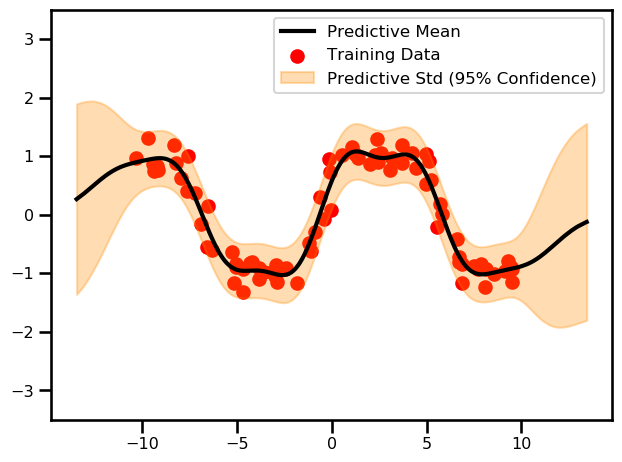

In [7]:
logger.setLevel(logging.INFO)

fig, ax = plt.subplots()

ax.scatter(X, y, c="red", label="Training Data")
ax.plot(
    Xtest.squeeze(),
    mu_y.squeeze(),
    label=r"Predictive Mean",
    color="black",
    linewidth=3,
)
ax.fill_between(
    Xtest.squeeze(),
    mu_y.squeeze() + uncertainty,
    mu_y.squeeze() - uncertainty,
    alpha=0.3,
    color="darkorange",
    label=f"Predictive Std (95% Confidence)",
)
ax.set_ylim([-3.5, 3.5])
ax.legend(fontsize=12)

plt.tight_layout()
fig.savefig(PATH.joinpath("figures/jaxgp/examples/mc/1d_gp.png"))
plt.show()

## Uncsented Transformation

In [8]:
from typing import Optional
def unscented_sigma_points(
    n_features: int, kappa: Optional[float]=None, alpha: float=1.0
):
    """Unscented sigma points
    
    Parameters
    ----------
    n_features : int,
        dimenion of the input random variables
    
    kappa : float, Optional
        scaling parameter
    
    alpha : float, Optional, default=1.0
        parameter affecting the covariance
    
    Returns
    -------
    sigma_points : np.ndarray, (n_features, n_sigma_points)
        Unscented sigma points
    """
    kappa = jnp.max([3.0 - n_features, 0.0]) if kappa is None else kappa
    
    lam = alpha ** 2 * (n_features + kappa) - n_features
    c = jnp.sqrt(n_features + lam)
    
    sigma_points = jnp.hstack((
        jnp.zeros((n_features, 1)), 
        c * jnp.eye(n_features),
        - c * jnp.eye(n_features)
    ))
    return sigma_points

def unscented_weights(
    n_features: int,
    kappa: Optional[float]=None, 
    alpha: float=1.0,
    beta: float=2.0,
):
    """Unscented transform weights.
    
    Parameters
    ----------
    n_features : int
        Dimension of the input random variable.
    kappa : float, optional
        Scaling parameter.
    alpha : float, optional
        Parameter affecting covariance.
        Controls the spread of points (1e-3, 1)
    beta : float, optional
        Parameter affecting covariance.
        Used to encode additional (high-order) knowledge about the 
        underlying Gaussian representation
    Returns
    -------
    w : (num_points, ) ndarray
        Unscented weights for the transformed mean.
    wc : (num_points, ) ndarray
        Unscented weights for the transformed covariance.
    """
    kappa = jnp.max([3.0 - n_features, 0.0]) if kappa is None else kappa
    lam = alpha ** 2 * (n_features + kappa) - n_features
    wm = 1.0 / (2.0 * (n_features + lam)) * jnp.ones(2 * n_features)
    wc = wm.copy()
    wm0 = lam / (n_features + lam)
    wc0 = wm0 + (1 - alpha ** 2 + beta)
    return jnp.hstack((wm0, wm)), jnp.hstack((wc0, wc))

In [9]:
X.shape, input_cov.shape
logger.setLevel(logging.DEBUG)
n_features = X.shape[1]
n_mc_samples = 1000

# sigma point transform parameters
alpha = 1.
beta = 20.0
kappa = 1.


Wm, Wc = unscented_weights(n_features, kappa=kappa, alpha=alpha)
Wm = jnp.diag(Wm)
Wc = jnp.diag(Wc)
logging.debug(f"Wm, Wc: {Wm.shape}, {Wc.shape}")
# get unit sigma points
key = jax.random.PRNGKey(0)
unit_sigma_points = unscented_sigma_points(n_features, kappa=kappa, alpha=alpha)
logging.debug(f"Sigma Points: {unit_sigma_points.shape}")
logging.debug(f"Xtest: {Xtest.shape}")
# form sigma-points from unit sigma-points
x_ = Xtest + jnp.dot(jnp.linalg.cholesky(input_cov), unit_sigma_points)
logging.debug(f"x_: {x_.shape}")

# push sigma points through non-linearity
mu_f = functools.partial(predictive_mean, params, gp_priors, X, y)
mu_f_batch = jax.jit(jax.vmap(mu_f, in_axes=(0)))

outputs = mu_f_batch(x_)
logging.debug(f"outputs: {outputs.shape}")
# output mean
outputs_mean = jnp.mean(outputs, axis=1).T
logging.debug(f"outputs (mean): {outputs_mean.shape}")

# output covariance
# logging.debug(f"Cov: {outputs.shape}, {outputs_mean.shape}")
dfx = outputs - outputs_mean[:, None]
logging.debug(f"dfx: {dfx.shape}")

cov_f = jnp.dot(jnp.dot(dfx,Wc), dfx.T)
logging.debug(f"cov_f: {cov_f.shape}")

2020-05-25 19:11:49,903:DEBUG:Compiling _where for args (ShapedArray(bool[3,3]), ShapedArray(float32[3]), ShapedArray(float32[3])).
2020-05-25 19:11:49,941:DEBUG:Wm, Wc: (3, 3), (3, 3)
2020-05-25 19:11:50,013:DEBUG:Sigma Points: (1, 3)
2020-05-25 19:11:50,014:DEBUG:Xtest: (1000, 1)
2020-05-25 19:11:50,091:DEBUG:x_: (1000, 3)
2020-05-25 19:11:50,103:DEBUG:Compiling gram for args (ShapedArray(float32[]), ShapedArray(float32[]), ShapedArray(float32[]), ShapedArray(float32[80,1]), ShapedArray(float32[80,1])).
2020-05-25 19:11:50,154:DEBUG:Compiling _cholesky for args (ShapedArray(float32[80,80]),).
2020-05-25 19:11:50,200:DEBUG:Compiling _cho_solve for args (ShapedArray(float32[80,80]), ShapedArray(float32[80,1])).
2020-05-25 19:11:50,240:DEBUG:Compiling <unnamed function> for args (ShapedArray(float32[1000,3]),).
2020-05-25 19:11:50,290:DEBUG:outputs: (1000, 3)
2020-05-25 19:11:50,336:DEBUG:outputs (mean): (1000,)
2020-05-25 19:11:50,354:DEBUG:dfx: (1000, 3)
2020-05-25 19:11:50,392:DEBUG:

In [15]:
# uncertainty = 1.96 * jnp.sqrt(jnp.diag(cov_f))
uncertainty = 1.96 * (jnp.sqrt(jnp.diag(cov_f)) + jnp.sqrt(var_y.squeeze()))

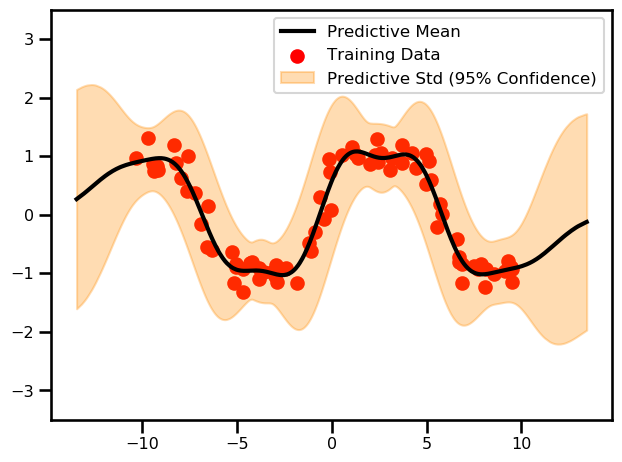

In [16]:
logger.setLevel(logging.INFO)

fig, ax = plt.subplots()

ax.scatter(X, y, c="red", label="Training Data")
ax.plot(
    Xtest.squeeze(),
    mu_y.squeeze(),
    label=r"Predictive Mean",
    color="black",
    linewidth=3,
)
ax.fill_between(
    Xtest.squeeze(),
    mu_y.squeeze() + uncertainty,
    mu_y.squeeze() - uncertainty,
    alpha=0.3,
    color="darkorange",
    label=f"Predictive Std (95% Confidence)",
)
ax.set_ylim([-3.5, 3.5])
ax.legend(fontsize=12)

plt.tight_layout()
fig.savefig(PATH.joinpath("figures/jaxgp/examples/unscented/1d_gp_un.png"))
# fig.savefig("figures/jaxgp/examples/mc/1d_gp_mc.png")
plt.show()

### More Points

In [12]:
from typing import Optional
def unscented_weights(
    n_features: int,
    kappa: Optional[float]=None, 
    alpha: float=1.0,
    beta: float=2.0,
):
    """Unscented transform weights.
    
    Parameters
    ----------
    n_features : int
        Dimension of the input random variable.
    kappa : float, optional
        Scaling parameter.
    alpha : float, optional
        Parameter affecting covariance.
        Controls the spread of points (1e-3, 1)
    beta : float, optional
        Parameter affecting covariance.
        Used to encode additional (high-order) knowledge about the 
        underlying Gaussian representation
    Returns
    -------
    w : (num_points, ) ndarray
        Unscented weights for the transformed mean.
    wc : (num_points, ) ndarray
        Unscented weights for the transformed covariance.
    """
    tau = alpha ** 2 * (n_features + kappa) - n_features
    weight_mean_0 = tau / (n_features + tau)
    weight_cov_0 = tau / (n_features + tau) + (1 - alpha ** 2 + beta)
    weight = 1. / ( 2. * (n_features + tau) )
    gamma = jnp.sqrt(n_features + tau)

    return gamma, weight, weight_mean_0, weight_cov_0

In [13]:
def generate_sigma_points(
    x_mu, x_cov, gamma
):
    """Unscented sigma points
    
    Parameters
    ----------
    n_features : int,
        dimenion of the input random variables
    
    kappa : float, Optional
        scaling parameter
    
    alpha : float, Optional, default=1.0
        parameter affecting the covariance
    
    Returns
    -------
    sigma_points : np.ndarray, (n_features, n_sigma_points)
        Unscented sigma points
    """
    term = gamma * np.sqrt(x_cov.T)
    ksigma_points = np.vstack((x_mu, x_mu + term, x_mu - term))
    return sigma_points

In [14]:
gamma, weight, weight_mean_0, weight_cov_0 = unscented_weights(
    n_features=X[0].shape[0],
    kappa=0, alpha=1., beta=2.
    
)

sigma_points = generate_sigma_points(X[0], input_cov, gamma)
sigma_points.shape

NameError: name 'sigma_points' is not defined